In [6]:
# 1. Limpiar instalaciones corruptas o incompatibles
!pip uninstall -y numpy tensorflow keras matplotlib scikit-learn scipy pandas

# 2. Instalar versión segura de NumPy primero
!pip install numpy==1.24.4

# 3. Reinstalar los módulos dependientes recompilados para NumPy 1.24.4
!pip install --no-cache-dir --force-reinstall \
    scikit-learn \
    scipy \
    matplotlib==3.7.3 \
    pandas

# 4. Instalar TensorFlow (trae keras integrado)
!pip install tensorflow


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: matplotlib 3.7.3
Uninstalling matplotlib-3.7.3:
  Successfully uninstalled matplotlib-3.7.3
Found existing installation: scikit-learn 1.7.0
Uninstalling scikit-learn-1.7.0:
  Successfully uninstalled scikit-learn-1.7.0
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: pandas 2.3.0
Uninstalling pandas-2.3.0:
  Successfully uninstalled pandas-2.3.0
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Consider adding

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
import random
import numpy as np

# -------------------------------------------------------------------------
#config de directorios
zip_path = '../Visual_Lab_V6/Visual_Lab_V6'
extract_to = './dataset'
train_dir = './train'
test_dir = './test'

# config de la particion train_test
CLASSES = ['Sick', 'Healthy'] # de aqui he quitado unknown
TEST_SIZE = 0.2  # 20% test
SEED = 73745

random.seed(SEED)
np.random.seed(SEED)

pacientes_a_eliminar = {
    'Healthy': ['003', '010', '018', '092', '094', '114', '156', '185', '197', '206'],
    'Sick': ['242', '258']
}
# -------------------------------------------------------------------------

shutil.rmtree(extract_to, ignore_errors=True)
for cls in CLASSES:
    src_cls_path = os.path.join(zip_path, 'BBDD', cls)
    dst_cls_path = os.path.join(extract_to, 'Visual_Lab_V6', 'BBDD', cls)
    for paciente in os.listdir(src_cls_path):
        paciente_path = os.path.join(src_cls_path, paciente)
        if not os.path.isdir(paciente_path):
            continue  # Ignorar archivos como .DS_Store

        pid = paciente.split('_')[-1]
        if pid in pacientes_a_eliminar.get(cls, []):
            continue

        dst_paciente_path = os.path.join(dst_cls_path, paciente)
        os.makedirs(dst_paciente_path, exist_ok=True)
        for archivo in os.listdir(paciente_path):
            if archivo.endswith('_normalizado.jpeg'):
                shutil.copy(
                    os.path.join(paciente_path, archivo),
                    os.path.join(dst_paciente_path, archivo)
                )

for path in [train_dir, test_dir]:
    shutil.rmtree(path, ignore_errors=True)
    for cls in CLASSES:
        os.makedirs(os.path.join(path, cls), exist_ok=True)

def recopilar_imagenes():
    """Devuelve una lista con todos los paths de imágenes por clase"""
    base_path = os.path.join(extract_to, 'Visual_Lab_V6', 'BBDD')
    data = {'Sick': [], 'Healthy': []}
    for cls in CLASSES:
        cls_path = os.path.join(base_path, cls)
        pacientes = sorted([d for d in os.listdir(cls_path) if d.startswith('paciente_')])
        for paciente in pacientes:
            pac_path = os.path.join(cls_path, paciente)
            for img in sorted(os.listdir(pac_path)):
                if img.endswith('.jpeg'):
                    src = os.path.join(pac_path, img)
                    filename = f"{paciente}_{img}"
                    data[cls].append((src, filename))
    return data

def split_y_copiar(data):
    """Particiona imágenes y copia a carpetas de train/test"""
    for cls in CLASSES:
        imagenes = data[cls]
        train, test = train_test_split(imagenes, test_size=TEST_SIZE, random_state=SEED)
        for subset, subset_dir in [(train, train_dir), (test, test_dir)]:
            dest_path = os.path.join(subset_dir, cls)
            for src, filename in subset:
                shutil.copy(src, os.path.join(dest_path, filename))

def balancear_split(split_dir):
    """Equilibra Sick y Healthy en un directorio dado (train o test)"""
    counts = {}
    paths = {}
    for cls in CLASSES:
        cls_path = os.path.join(split_dir, cls)
        files = sorted([os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpeg')])
        counts[cls] = len(files)
        paths[cls] = files

    # Determinar cuál es la clase mayoritaria
    cls_mayor = max(counts, key=counts.get)
    cls_menor = min(counts, key=counts.get)
    exceso = counts[cls_mayor] - counts[cls_menor]

    if exceso > 0:
        print(f"[{os.path.basename(split_dir)}] Eliminando {exceso} imágenes de '{cls_mayor}'")
        random.seed(SEED)
        eliminar = random.sample(paths[cls_mayor], exceso)
        for f in eliminar:
            os.remove(f)

# ==================== EJECUCIÓN ====================
# Recopilar todas las imágenes
data = recopilar_imagenes()

# Split y copiado
split_y_copiar(data)

# Balanceo post-copiado
balancear_split(train_dir)
balancear_split(test_dir)

# Contar resultados finales
for split_dir in [train_dir, test_dir]:
    print(f"\n[{os.path.basename(split_dir).upper()}]")
    for cls in CLASSES:
        n = len([f for f in os.listdir(os.path.join(split_dir, cls)) if f.endswith('.jpeg')])
        print(f"{cls}: {n} imágenes")

[train] Eliminando 5117 imágenes de 'Healthy'
[test] Eliminando 1279 imágenes de 'Healthy'

[TRAIN]
Sick: 1749 imágenes
Healthy: 1749 imágenes

[TEST]
Sick: 438 imágenes
Healthy: 438 imágenes


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMG_SIZE = (256, 256)  # Asegúrate de que tus CNN estén diseñadas para este tamaño
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    # rescale=1./255,
    validation_split=0.1  # Separación interna de validación
)

test_datagen = ImageDataGenerator(#rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

NUM_CLASSES = len(train_gen.class_indices)
print(f"Clases detectadas: {train_gen.class_indices}")

Found 3150 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Found 876 images belonging to 2 classes.
Clases detectadas: {'Healthy': 0, 'Sick': 1}


In [13]:
!pip install --no-cache-dir --force-reinstall matplotlib==3.7.3

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 48.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 KB 303.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 353.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 KB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 65.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninsta

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # silencia warnings de TensorFlow
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="  # desactiva rutas fantasma de XLA
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.initializers import HeNormal

# ==============================
# CONFIGURACIÓN GENERAL
# ==============================
IMG_SIZE = (256, 256)
EPOCHS = 50
MODELS_DIR = './saved_models'
os.makedirs(MODELS_DIR, exist_ok=True)

# ==============================
# EXPERIMENTOS DEFINIDOS
# ==============================

EXPERIMENTS = [
    {
        'name': 'EfficientNetB0-Strict-FromScratch',
        'base_model': EfficientNetB0(include_top=False, weights=None),
        'trainable': True,
        'lr': 0.001,
        'dropout': 0.5,
        'optimizer': Adam,
        'kernel_initializer': HeNormal()
    },
    {
        'name': 'EfficientNetB0-Permissive-FromScratch',
        'base_model': EfficientNetB0(include_top=False, weights=None),
        'trainable': True,
        'lr': 0.001,
        'dropout': 0.5,
        'optimizer': Adam,
        'kernel_initializer': HeNormal()
    },
    {
        'name': 'ResNet50-Strict-FromScratch',
        'base_model': ResNet50(include_top=False, weights=None),
        'trainable': True,
        'lr': 0.001,
        'dropout': 0.5,
        'optimizer': Adam,
        'kernel_initializer': HeNormal()
    },
    {
        'name': 'ResNet50-Permissive-FromScratch',
        'base_model': ResNet50(include_top=False, weights=None),
        'trainable': True,
        'lr': 0.001,
        'dropout': 0.5,
        'optimizer': Adam,
        'kernel_initializer': HeNormal()
    }
]


# ==============================
# FUNCIÓN DE ENTRENAMIENTO
# ==============================
def train_and_save_model(cfg):
    base_model = cfg['base_model']
    base_model.trainable = cfg['trainable']

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    if cfg['dropout'] > 0:
        x = layers.Dropout(cfg['dropout'])(x)

    outputs = layers.Dense(1, activation='sigmoid', kernel_initializer=cfg['kernel_initializer'])(x) # cambiar activacion 
    model = tf.keras.Model(inputs, outputs)

    optimizer_instance = cfg['optimizer'](learning_rate=cfg['lr'])
    model.compile(
        optimizer=optimizer_instance,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    early_stop = callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    )

    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR, f"{cfg['name']}.keras"),
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )

    print(f"\n{'='*50}\nEntrenando: {cfg['name']}\n{'='*50}")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop, model_checkpoint]
    )

    test_results = model.evaluate(test_gen, verbose=0)
    print(f"\nResultados para {cfg['name']}:")
    print(f"  Test Accuracy: {test_results[1]:.4f}")
    print(f"  Test AUC: {test_results[2]:.4f}")

    # Gráficas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{cfg['name']} - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f"{cfg['name']} - AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return test_results

# ==============================
# EJECUCIÓN DE EXPERIMENTOS
# ==============================
results = {}
for cfg in EXPERIMENTS:
    try:
        test_results = train_and_save_model(cfg)
        results[cfg['name']] = test_results
    except Exception as e:
        print(f"\n⚠️ Error en {cfg['name']}: {str(e)}")

# ==============================
# RESUMEN Y GUARDADO
# ==============================
print("\n\nRESUMEN DE TODOS LOS MODELOS:")
print("{:<25} {:<15} {:<15}".format('Modelo', 'Accuracy', 'AUC'))
print("-"*50)
for name, res in results.items():
    print("{:<25} {:<15.4f} {:<15.4f}".format(name, res[1], res[2]))

# Exportar CSV
df_results = pd.DataFrame.from_dict({
    name: {'Accuracy': res[1], 'AUC': res[2]} for name, res in results.items()
}).T
df_results.to_csv(os.path.join(MODELS_DIR, 'resultados_comparativos.csv'))
print(f"\nResultados guardados en {MODELS_DIR}")


📁 Modelos encontrados: ['EfficientNetB0-Permissive-FromScratch.keras', 'EfficientNetB0-Strict-FromScratch.keras', 'ResNet50-Strict-FromScratch.keras', 'ResNet50-Permissive-FromScratch.keras']


🔍 Evaluando modelo: EfficientNetB0-Permissive-FromScratch.keras
✅ Accuracy: 0.5000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       438
        Sick       0.50      1.00      0.67       438

    accuracy                           0.50       876
   macro avg       0.25      0.50      0.33       876
weighted avg       0.25      0.50      0.33       876



/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

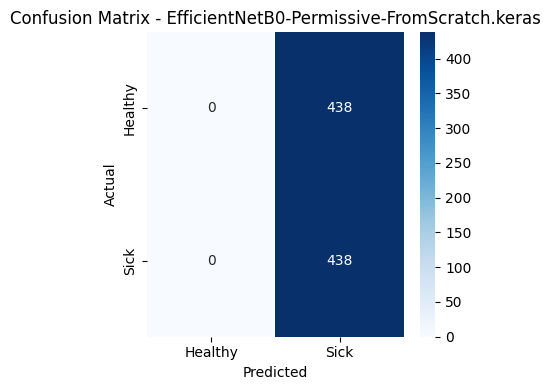


🔍 Evaluando modelo: EfficientNetB0-Strict-FromScratch.keras
✅ Accuracy: 0.5913

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.55      0.93      0.70       438
        Sick       0.79      0.25      0.38       438

    accuracy                           0.59       876
   macro avg       0.67      0.59      0.54       876
weighted avg       0.67      0.59      0.54       876



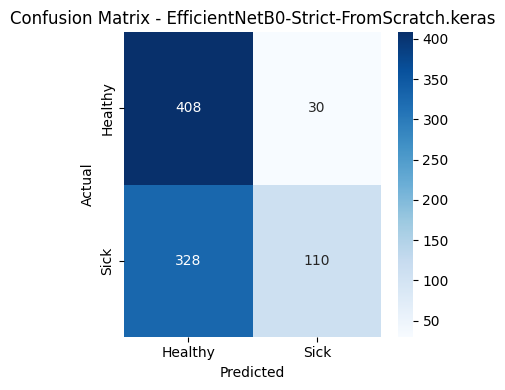


🔍 Evaluando modelo: ResNet50-Strict-FromScratch.keras
✅ Accuracy: 0.5000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       438
        Sick       0.50      1.00      0.67       438

    accuracy                           0.50       876
   macro avg       0.25      0.50      0.33       876
weighted avg       0.25      0.50      0.33       876



/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/22014885carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

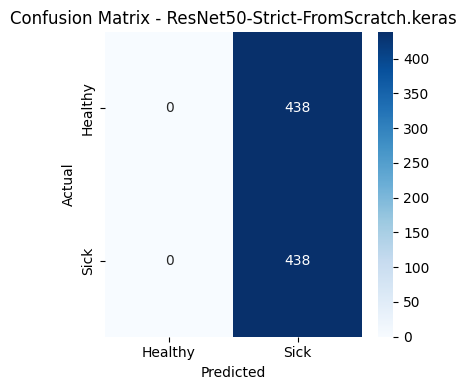


🔍 Evaluando modelo: ResNet50-Permissive-FromScratch.keras
✅ Accuracy: 0.4852

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.28      0.02      0.03       438
        Sick       0.49      0.95      0.65       438

    accuracy                           0.49       876
   macro avg       0.38      0.49      0.34       876
weighted avg       0.38      0.49      0.34       876



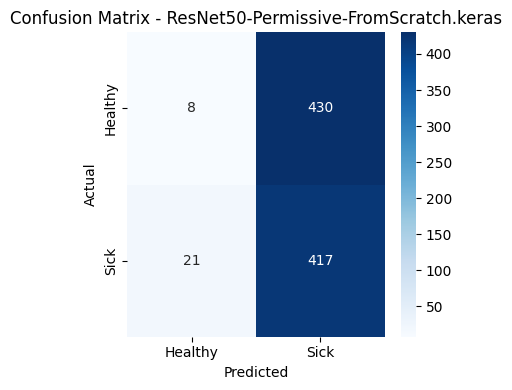

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Ruta a los modelos
MODELS_DIR = './saved_models'

# Listado de modelos a probar (ajusta los nombres si son distintos)
model_names = [
    'EfficientNetB0-Permissive-FromScratch.keras',
    'EfficientNetB0-Strict-FromScratch.keras',
    'ResNet50-Strict-FromScratch.keras',
    'ResNet50-Permissive-FromScratch.keras'
]

print(f"📁 Modelos encontrados: {model_names}\n")

# Obtener predicciones del generador (sin barajar)
test_gen.reset()
X_test, y_test = [], []
for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    X_test.extend(x_batch)
    y_test.extend(y_batch)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluar cada modelo
for model_file in model_names:
    model_path = os.path.join(MODELS_DIR, model_file)
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        continue

    print(f"\n🔍 Evaluando modelo: {model_file}")
    model = load_model(model_path)

    # Predicciones
    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Métricas
    acc = np.mean(y_pred == y_test)
    print(f"✅ Accuracy: {acc:.4f}")
    print("\n📋 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Healthy', 'Sick']))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
    plt.title(f"Confusion Matrix - {model_file}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
